# Practical Usage Example
## Introduction

In this notebook, you can find how to capture a signal from a PDM microphone using the Raspberry Pi Pico. Before you begin, ensure that you have already uploaded the firmware to your Raspberry Pi Pico and have a microphone connected as described in the README.md of the repository.

Additionally, you will need to determine the serial port name assigned to the Raspberry Pi Pico by your operating system.

As a sound source, I simply use my smartphone to generate a tone signal with a frequency of 8000 Hz placed close to the microphone.

## Imports

In this Notebook, I am using the following libraries:

    - numpy 1.26.4
    - pyserial 3.5
    - matplotlib 3.5.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import serial
import serial.threaded
import time

print(f'numpy {np.__version__}')
print(f'serial {serial.__version__}')
print(f'matplotlib {matplotlib.__version__}')

numpy 1.26.4
serial 3.5
matplotlib 3.5.1


## Serial Data Logger Class
This Python code defines a class called `SerialReader` that subclasses `serial.threaded.Protocol`. Here's a breakdown of its functionality:

**`SerialReader(filename='test.bin')`**: This is the class constructor. It initializes an instance of the `SerialReader` class. It takes an optional argument `filename`, which defaults to 'test.bin'. Inside the constructor, it opens a binary file in write mode with the specified filename.

Overall, this class is designed to receive data over a serial connection and write it to a binary file.

**Note**: Long periods of time can be logged using this class because the data is saved in chunks




In [2]:
class SerialReader(serial.threaded.Protocol):
    def __init__(self, filename = 'test.bin'):
        self.data_bin = open(filename, "wb")

    def __call__(self):
        return self

    def data_received(self, data):
        self.data_bin.write(data)
        
    def close_bin(self):
        self.data_bin.close()
    # def set_file(filename):

    def __del__(self):        
        self.data_bin.close()

## Save Data to a File

You need to change the `port` to the serial port name assigned to the Raspberry Pi Pico by your operating system. The data will be saved in `data.bin` and will include 2 seconds of data.

**Note**: Each byte represents eight samples of data. If you are using the firmware from this repository, the sample rate will be 48,000 * 64 = 3,072,000 Hz. Therefore, 2 seconds of data will be 48,000 * 64 * 2 / 8 = 768,000 bytes.

In [ ]:
port = 'COM8'
ser = serial.Serial(port)
serial_reader = SerialReader('data.bin')
with serial.threaded.ReaderThread(ser, serial_reader) as protocol:
    # save some data for 2 seconds
    time.sleep(2)

## Open the file
Now we can open the file. 



In [3]:
with open("data.bin", mode="rb") as data_bin:
    data = data_bin.read()

print(f'Number of samples in data.bin: {len(data) * 8 }')

Number of samples in data.bin: 6094848


## Unpack bits function
This function will take a bytes array and will give you a binary-valued output array.
This can be easily done with help of [numpy.unpackbits](https://numpy.org/doc/stable/reference/generated/numpy.unpackbits.html)

Example:

```python
unpacked = unpackbits(bytes([2])))
print(unpacked)
```
```
output:
[0. 0. 0. 0. 0. 0. 1. 0.]
```

In [5]:
def unpackbits(data):
    data_np = np.frombuffer(data, dtype=np.uint8)
    data_1bit = np.unpackbits(data_np)
    data_1bit = data_1bit.astype(np.float64)
    return data_1bit
# data_1bit = np.zeros(N)
# ix = 0
# for val_8bits in data_slice:
#     for i in range(8):
#         data_1bit[ix] = (val_8bits >> (7 - i)) & 1
#         ix += 1

##  Plot a part of the data

Let's take the last 1024 samples and plot the signal

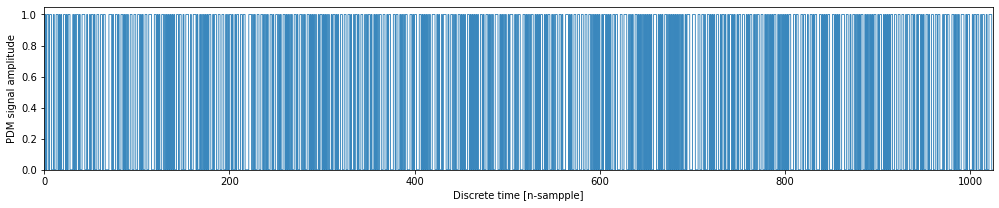

In [7]:
N = 1024
data_1bit = unpackbits(data[(-N // 8):])
fig, ax = plt.subplots( figsize=(17, 3))
ax.stairs(data_1bit, linewidth=0.8, alpha=1.)
ax.set_xlim(0,1024)
ax.set_xlabel('Discrete time [n-sampple]')
ax.set_ylabel('PDM signal amplitude')
plt.show()

## FFT of the Signal

To verify that everything is working correctly, we can plot the spectrum of the signal without decimating it. This will allow us to see the 8,000 Hz generated signal.

Additionally, above 48,000 / 2 = 24,000 Hz, we can observe the frequency content corresponding to the PDM.

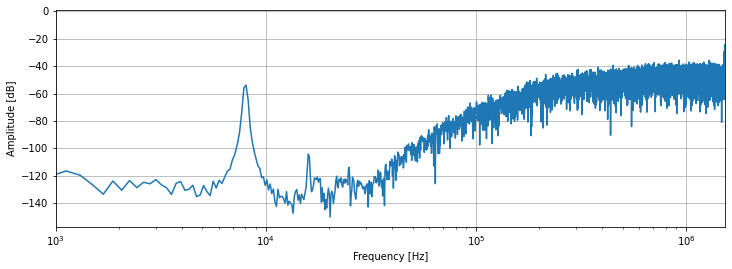

In [8]:
from scipy.fft import fft, fftfreq
from scipy import signal
N = 16384
data_1bit = unpackbits(data[(-N // 8):])

window = signal.windows.hann(N)
T = 1.0 / 48000.0 / 64.0
yf = fft(data_1bit * window)
# yf = fft(data_1bit)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(12, 4))
plt.semilogx(xf, 20.0 * np.log10(2.0/N * np.abs(yf[0:N//2])))
plt.grid()
plt.xlim(1000,xf[-1])
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.show()